Overview
In this module, you will work on performing exploratory data analysis (EDA) to develop an initial report for your capstone project. You will use EDA to see what data can reveal beyond the formal modeling, hypothesis testing task, and data training to provide a better understanding of dataset variables and the relationships between them. You are encouraged to spend your time in this module cleaning your data and use feature engineering and EDA techniques to create visualizations to make sense of your findings. Additionally, you will also be required to use one of the ML algorithms you have learned so far in the program to develop a baseline model to use as a comparison in Module 24. You will have time in Module 24 to include additional models, clean the code, and make your work presentable for technical and non-technical audiences. For now, you will do the ‘heavy lifting’ of finding the answer to your research question.

The only deliverables for this module will be the Jupyter notebook(s) where you did your analysis and the updated README.md Download README.mdfile with the results section completed. If you have changed methodologies or datasets since Module 16, please make sure you reflect those changes in the README.md Download README.mdfile as well.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:


# Get image paths to build a data frame of image paths and labels
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/Assigment_20_1/pictures/')
image_paths = list(data_dir.glob('*/*.png'))

# Create the data frame with columns 'path' and 'label'
image_data = pd.DataFrame({'path': image_paths})
image_data['label'] = image_data['path'].apply(lambda p: p.parent.name)


Total number of images: 10689

Class distribution:
label
happy    5538
sad      5151
Name: count, dtype: int64


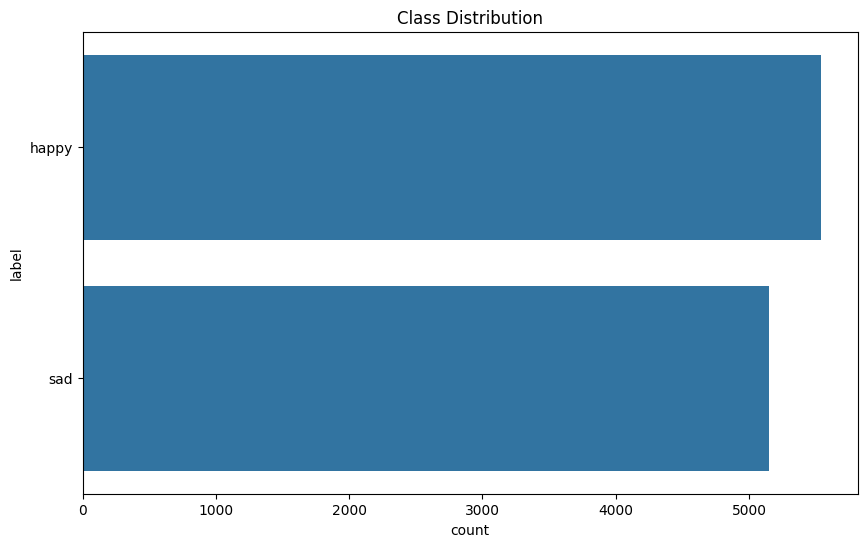

In [4]:
print(f"Total number of images: {len(image_data)}")
print("\nClass distribution:")
print(image_data['label'].value_counts())

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=image_data, y='label', order=image_data['label'].value_counts().index)
plt.title('Class Distribution')
plt.show()


In [5]:
image_data.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/Assigme...,happy
1,/content/drive/MyDrive/Colab Notebooks/Assigme...,happy
2,/content/drive/MyDrive/Colab Notebooks/Assigme...,happy
3,/content/drive/MyDrive/Colab Notebooks/Assigme...,happy
4,/content/drive/MyDrive/Colab Notebooks/Assigme...,happy


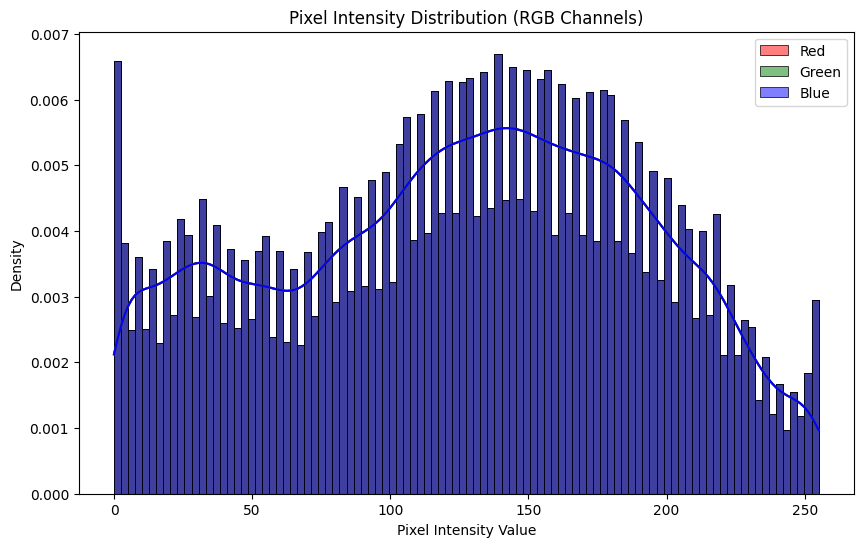

In [10]:
def analyze_color_distribution(df, num_samples=100):
    # Analyze a representative sample for performance
    sample_paths = df['path'].sample(num_samples)
    r_pixels, g_pixels, b_pixels = [], [], []

    for path in sample_paths:
        try:
            with Image.open(path) as img:
                # Ensure RGB mode
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Resize for consistent sampling (optional, but faster)
                img = img.resize((32, 32))
                img_array = np.array(img)
                r_pixels.extend(img_array[:, :, 0].ravel())
                g_pixels.extend(img_array[:, :, 1].ravel())
                b_pixels.extend(img_array[:, :, 2].ravel())
        except:
            continue

    plt.figure(figsize=(10, 6))
    sns.histplot(r_pixels, color='red', alpha=0.5, bins=100, label='Red', kde=True, stat="density")
    sns.histplot(g_pixels, color='green', alpha=0.5, bins=100, label='Green', kde=True, stat="density")
    sns.histplot(b_pixels, color='blue', alpha=0.5, bins=100, label='Blue', kde=True, stat="density")
    plt.title('Pixel Intensity Distribution (RGB Channels)')
    plt.xlabel('Pixel Intensity Value')
    plt.legend()
    plt.show()

analyze_color_distribution(image_data)


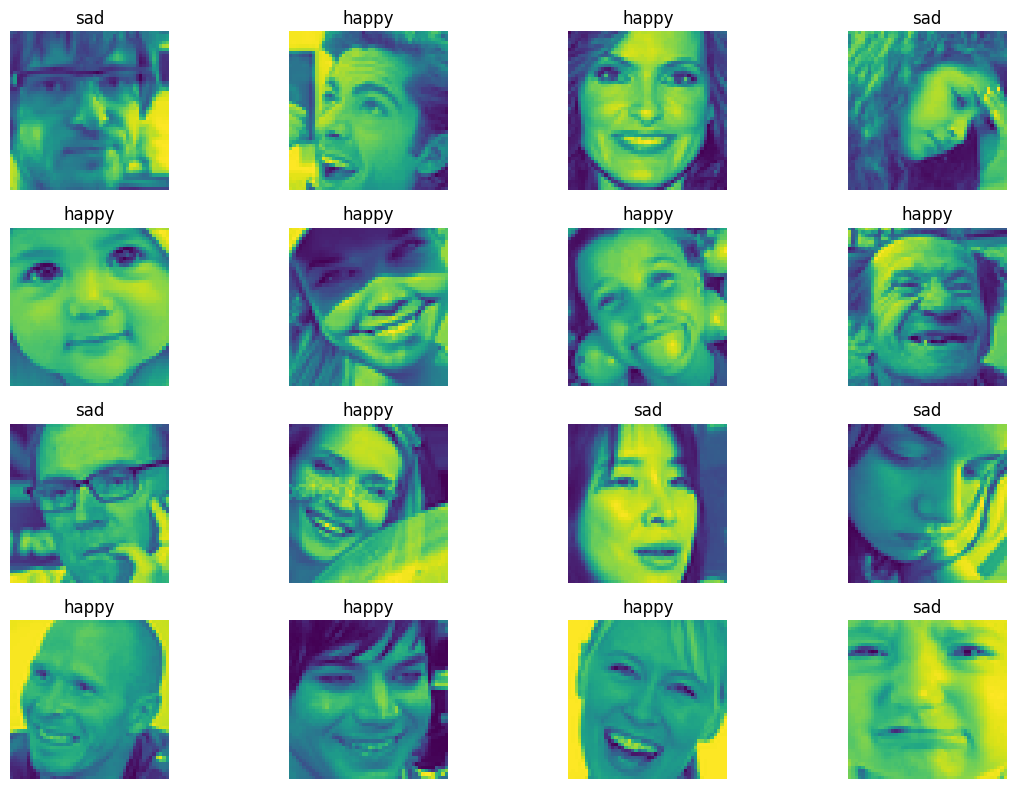

In [11]:
def display_samples(df):
    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img_path = df.iloc[i]['path']
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(df.iloc[i]['label'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_samples(image_data.sample(16))


In [6]:
def extract_hog_features(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image for uniformity (Recommended for image classification)
    resized_image = cv2.resize(image, (128, 64))

    # Get the HOG features, including visualization
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True,
                              block_norm='L2-Hys', visualize=True)

    return features, hog_image

In [7]:


def load_data_and_extract_features(data_directory):
    img_features = []
    img_labels = []
    for class_name in os.listdir(data_directory):
        class_dir = os.path.join(data_directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    features, _ = extract_hog_features(img_path)
                    img_features.append(features)
                    img_labels.append(class_name)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

    # Convert lists to numpy arrays
    X = np.array(img_features)
    y = np.array(img_labels)

    # Encode string
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X, y_encoded, le.classes_

X, y, class_names = load_data_and_extract_features('/content/drive/MyDrive/Colab Notebooks/Assigment_20_1/pictures/')






In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:


# Initialize the classifier with a number of trees (estimators)
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42,
                                       n_jobs=-1, class_weight='balanced')

# Fit the model
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=42)

Accuracy: 78.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1689
           1       0.75      0.83      0.79      1518

    accuracy                           0.79      3207
   macro avg       0.79      0.79      0.79      3207
weighted avg       0.79      0.79      0.79      3207



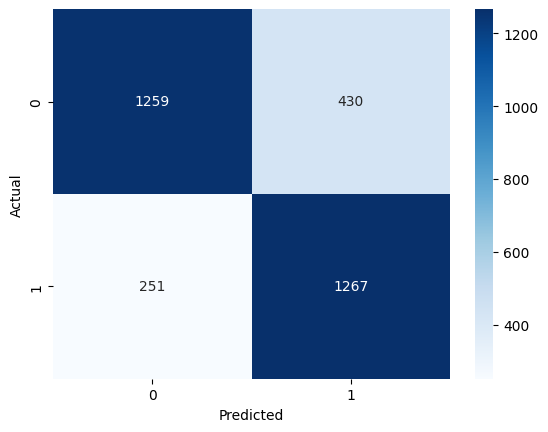

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
